# ............................................................................................................................................

# Welcome to the RAAIM

Use shift + enter to run a code block or move to the next text block.

Run the next block of code to intialize the program.

* If you run into a "C:\Users\labuser\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\io\excel.py:626 error", simply ignore it! The program will still be able to run.

In [25]:
import numpy as np
import glob
import scipy
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import time as t
from PIL import Image
import sys
import os, errno
import matplotlib.patches as patches
from pandas.plotting import autocorrelation_plot



def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

import os
import glob
import pandas as pd
from PIL import Image
import numpy as np

def load_RAAIM(folder, original=False):
    data = None
    roi_param = None
    im = None
    events_x = None
    events_y = None

    # Define patterns and find matching files
    pattern_deltaF = os.path.join(folder, '*delta_F_spikes.txt')
    pattern_S = os.path.join(folder, '*S_spikes.txt')
    pattern_png = os.path.join(folder, '*pretty_plot.png')

    files_deltaF = glob.glob(pattern_deltaF)
    files_S = glob.glob(pattern_S)
    files_png = glob.glob(pattern_png)

    # Load delta_F_spikes.txt
    if files_deltaF:
        file_to_read = files_deltaF[0]
        try:
            data = pd.read_csv(file_to_read, index_col='time(s)', sep='\t')
            print "Loaded 'delta_F_spikes.txt'"
        except Exception as e:
            print "Error loading 'delta_F_spikes.txt': {}".format(e)

    # Load S_spikes.txt
    if files_S:
        file_to_read = files_S[0]
        try:
            if data is None:
                data = pd.read_csv(file_to_read, index_col='time(s)', sep='\t')
            roi_param = pd.read_csv(file_to_read, index_col='ROI', sep='\t')
            print "Loaded 'S_spikes.txt'"
        except Exception as e:
            print "Error loading 'S_spikes.txt': {}".format(e)

    # Load pretty_plot.png
    if files_png:
        file_to_read = files_png[0]
        try:
            im = Image.open(file_to_read)  # MUST BE RGB
            print "Loaded 'pretty_plot.png'"
        except Exception as e:
            print "Error loading 'pretty_plot.png': {}".format(e)

    # Process data
    if data is not None and 'Unnamed: 0' in data.columns:
        del data['Unnamed: 0']

    if data is not None and roi_param is not None:
        try:
            roi_loc, roi_x, roi_y, data = lcpro_param_parse(roi_param, data, original=original)
            print "Configured Data"

            events_x, events_y = get_events(data=data, roi_param=roi_param)
            print "LCPro events extracted"
        except Exception as e:
            print "Error processing data: {}".format(e)
    else:
        print "Unable to process data: data or roi_param is missing"
        roi_loc, roi_x, roi_y = None, None, None

    # Create plots folder
    path = os.path.join(folder, "plots")
    try:
        mkdir_p(path)
        print "Made plots folder"
    except Exception as e:
        print "Error creating plots folder: {}".format(e)

    return data, roi_param, im, roi_loc, roi_x, roi_y, events_x, events_y

# Helper function to create directory if it doesn't exist (mkdir -p equivalent)
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
    
def lcpro_param_parse(roi_param, data , original):
    '''
    This function takes the Dataframe created by opening the 'Parameter List.txt' from LC_Pro. 
    '''
    roi_loc = roi_param[['X', 'Y']]
    roi_loc.drop_duplicates(inplace= True)
    roi_x = roi_loc['X'].tolist()
    roi_y = roi_loc['Y'].tolist()
    new_index = []
    for i in np.arange(len(roi_loc.index)):
        foo = int(roi_loc.index[i])
        new_index.append('Roi'+str(foo))
    roi_loc = DataFrame({'x':roi_x, 'y':roi_y}, index= new_index)
    
    if len(data.columns) != len(new_index) and original == True:
        sys.exit("The number of ROIs in the data file is not equal to the number of ROIs in the parameter file. That doesn't seem right, so I quit the function for you. Make sure you are loading the correct files, please.")
    
    if original == False:
        data = data[roi_loc.index]
    
    truth = (data.columns == roi_loc.index).tolist()
    
    if truth.count(True) != len(data.columns):
        sys.exit("The names on data and roi_loc are not identical. This will surely break everything later, so I shut down the program. Try loading these files again.")
    
    return roi_loc, roi_x, roi_y, data

def get_events(data, roi_param):
    '''
    extract the events from the roi_parameter list. It returns them as a pair of dictionaries.
    '''
    new_index = []
    for i in np.arange(len(roi_param.index)):
        new_index.append('Roi'+str(roi_param.index[i]))
    roi_events = DataFrame(index= new_index)
    roi_events_time = roi_param['Time(s)'].tolist()
    roi_events_amp = roi_param['Amp(F/F0)'].tolist()
    roi_events['Time'] = roi_events_time
    roi_events['Amp'] = roi_events_amp
    
    events_x = {}
    events_y = {}
    for label in data.columns:
        events_x[label] = []
        events_y[label] = []

    for i in np.arange(len(roi_events.index)):
        key = roi_events.index[i]
        events_x[key].append(roi_events.iloc[i,0])
        events_y[key].append(roi_events.iloc[i,1])
        
    return events_x, events_y

def cross_correlation(data, r):
    '''
    This function calculated the cross elation between each ROI pair and returns a dataframe with NxN+1  values.
    it also includes a column that contains the number of friends each ROI has.
    lastly, it creates a dictionary where the keys are the roi names and names of each roi's friends are stored as a list. by defalut, each roi is at least friends with itself.
    this file can be saved out as a CSV later.
    '''
    
    data_corr = data.corr()
    ls = (data_corr[data_corr>r].count())
    data_corr['Number of Friends'] = ls
    cols = data_corr.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data_corr = data_corr[cols]
    
    friend_names = {}
    temp_cor = data.corr()
    correlation_summary = DataFrame()
    
    for label, column in temp_cor.iteritems():
        friend_names[label] = column[column>r].index.tolist()
        friends = column[column>r]
        summary = friends.describe()
        correlation_summary[label] = np.round(summary, 3)

    return data_corr, friend_names, correlation_summary

def distance_matrix(roi_x, roi_y , roi_loc , d):
    '''
    This function calculates the euclidean distance between each ROI pair. It returns a dataframe with these distances.
    it also includes a column that contains the number of neighbors each ROI has.
    the files can be saved out as a CSV later.
    It also returns the list of the (x,y) tuple for each roi.
    '''
    loc_tup = []
    for i in np.arange(len(roi_x)):
        loc_tup.append((roi_x[i], roi_y[i]))
    
    roi_dist = DataFrame(data = (scipy.spatial.distance.cdist(loc_tup, loc_tup, 'euclidean')), index = roi_loc.index, columns= roi_loc.index)
    roi_dist_f = roi_dist
    
    neighbor_names = {}
    distance_summary = DataFrame()
    
    for label, column in roi_dist.iteritems():
        neighbor_names[label] = column[column<=d].index.tolist()
        neighbors = column[column<=d]
        summary = neighbors.describe()
        distance_summary[label] = np.round(summary, 3)

    ls = (roi_dist[roi_dist<=d].count())
    roi_dist_f['Number of Neighbors'] = ls
    cols = roi_dist_f.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    roi_dist_f = roi_dist_f[cols]
    
    return roi_dist_f, loc_tup, neighbor_names, distance_summary

def friend_dist(data_corr, roi_dist, friend_names, r, d):
    '''
    calculates distance information about each roi's friends.
    returns a dataframe with Distance Sum, number of friends, and mean distance. mean dist = distance sum/number of fiends
    '''
    roi_friend_dist = DataFrame(index = data_corr.index)
    #roi_friend_dist['Distance sum'] = (roi_dist[data_corr>r].sum())
    roi_friend_dist['Number of Friends'] = (data_corr[data_corr>r].count())
    roi_friend_dist['Mean Dist'] = (roi_dist[data_corr>r].mean())
    roi_friend_dist['Std Dist'] = (roi_dist[data_corr>r].std())
    
    perc_friends_are_neighbors = Series(index = roi_dist.index) #empty series
    for key in friend_names:
        temp_series = roi_dist.loc[key, friend_names[key]]
        count = temp_series[temp_series<=d].count()
        perc_friends_are_neighbors[key] = count
    roi_friend_dist['Number of Friends that are Neighbors'] = perc_friends_are_neighbors
    roi_friend_dist['Percentage of Friends that are Neighbors'] = (roi_friend_dist['Number of Friends that are Neighbors']/roi_friend_dist['Number of Friends'])*100
    
    return roi_friend_dist

def neighbor_corr(roi_dist, data_corr, neighbor_names, r, d):
    '''
    Calculates correlation information about each roi's neighbors.
    returns dataframe with corr of neighbors, corr of neighbors that are friends, percent of neighbors that are friends
    '''
    
    roi_neighbor_corr = DataFrame(index = roi_dist.index)
    roi_neighbor_corr['Number of Neighbors'] = (roi_dist[roi_dist<=d].count())
    roi_neighbor_corr['Mean Correlation'] = (data_corr[roi_dist<=d].mean())
    roi_neighbor_corr['Std Correlation'] = (data_corr[roi_dist<=d].std())
    
    perc_neighbors_are_friends = Series(index = roi_dist.index)
    for key in neighbor_names:
        temp_series = data_corr.loc[key, neighbor_names[key]]
        count = temp_series[temp_series>r].count()
        perc_neighbors_are_friends[key] = count
    roi_neighbor_corr['Number of Neighbors that are Friends'] = perc_neighbors_are_friends
    roi_neighbor_corr['Percentage of Neighbors that are Friends'] = (roi_neighbor_corr['Number of Neighbors that are Friends']/roi_neighbor_corr['Number of Neighbors'])*100
    
    return roi_neighbor_corr

def onpick(event):
    '''
    allows us to click on an roi and print in the notebook it's name.
    '''
    ind = event.ind
    ind = ind[0]
    print('Roi selected =', roi_loc.index[ind])
    
def all_roi_2d(roi_loc , im , s=6):
    '''
    makes a scatter plot of each roi overlayed on an uploaded image. when you click on an roi, it prints the name of the roi
    for some reason, it takes two clicks to start printing. Not sure why
    '''
    fig, ax = plt.subplots()
    col = ax.scatter(roi_loc.x, roi_loc.y, s=s, edgecolor = 'k', linewidth ='1',color = 'y', marker ="o", alpha = 0.75, picker = True)
    fig.canvas.mpl_connect('pick_event', onpick)

    width, height = im.size
    plt.xlim(xmin=0, xmax=width)
    plt.ylim(ymin = 0, ymax = height)
    plt.title('All LC_Pro ROIs')
    plt.imshow(im)
    plt.show()
    
def friend_roi_2d(data_corr , friend_names, roi_loc, r, d, roi, just_friends, s = 6):
    temp_series_list = data_corr[roi].tolist()
    temp_series = data_corr[roi]
    temp_ls = temp_series[friend_names[roi]]

    fig, ax = plt.subplots()
    if just_friends == False:
        plt.scatter(roi_loc.x, roi_loc.y, s = s, label = 'other objects', edgecolor = 'k', linewidth ='1',c= temp_series_list,cmap=plt.cm.spectral , marker ="o", alpha = 1)
        plt.colorbar()
        plt.clim(-1,1)

        
    if just_friends == True:    
        plt.scatter(roi_loc.x, roi_loc.y, s = s, label = 'other objects', edgecolor = 'k', linewidth ='1',color= 'w' , marker ="o", alpha = 0.25)
        plt.scatter(roi_loc.x[friend_names[roi]], roi_loc.y[friend_names[roi]], label = 'Friends', s=s, edgecolor = 'k', linewidth ='1',c =temp_ls, cmap=plt.cm.spectral , marker ="o", alpha = 1)
        plt.colorbar()
        plt.clim(r,1)
        
    plt.scatter(roi_loc.x[roi], roi_loc.y[roi], label = roi, s=(s+25), edgecolor = 'k', marker ="o", alpha = 1, color = 'w')
    neighborhood = patches.Circle(xy = (roi_loc.x[roi], roi_loc.y[roi]), radius=d, fill = False, color= 'w', lw = 1, ls = 'solid')
    ax.add_artist(neighborhood)
    
    width, height = im.size
    plt.xlim(xmin=0, xmax=width)
    plt.ylim(ymin = 0, ymax = height)
    plt.title(roi)
    plt.imshow(im)
    #plt.legend(loc = 'center left')

    #plt.show()
    plt.savefig(r'%s/friend_2d(r=%s)(d=%s).png' %(folder,r,d))
    
def all_roi_line_pdfs(dataframe, num_rois, ymin, ymax, events_x, events_y, folder):
    
    for r in np.arange(num_rois):
        
        plt.figure()
        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title(dataframe.columns[r])
        plt.ylim(ymin = ymin, ymax = ymax)
        plt.xlim(xmin= dataframe.index[0], xmax = dataframe.index[-1])
        plt.plot(dataframe.index, dataframe.ix[:,r], color = [np.random.random(), np.random.random(), np.random.random()])
        plt.plot(events_x[dataframe.columns[r]], events_y[dataframe.columns[r]],  marker = "^", color="y", linestyle= "None")
        
        plt.savefig(r'%s/plots/%s.pdf' %(folder,dataframe.columns[r]))
        plt.close()
        
def roi_line_plot(roi, dataframe, events_x, events_y, ymin, ymax):
    
    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.title(roi)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.xlim(xmin= dataframe.index[0], xmax = dataframe.index[-1])
    plt.plot(dataframe.index, dataframe.ix[:,roi], color = 'k')
    plt.plot(events_x[roi], events_y[roi],  marker = "^", color="y", linestyle= "None")

    plt.show()
    
    
def friend_roi_line(data, friend_names, roi, folder):
    plt.figure()
    plt.plot(data.index, data[friend_names[roi]], color = '#FF6600')
    plt.plot(data.index, data[roi], color = 'k',)
    plt.ylim(ymin = 0, ymax = max(data.max()))
    plt.title(roi)

    #plt.show()
    plt.savefig(r'%s/friend_line(r=%s)(d=%s).png' %(folder,r,d))
    
def friend_roi_line_average(data, friend_names, roi):
    roi_average = data[friend_names[roi]].mean(1)
    roi_std = data[friend_names[roi]].std(1)
    print "the average of the std of each point is", round(np.mean(roi_std),4), "for", roi, "and its friends."

    plt.figure()
    plt.plot(data[friend_names[roi]].mean(1))
    plt.ylim(ymin = 0, ymax = max(data.max()))
    plt.title('Average of '+roi+' and its friends')
    plt.show()

def boxandwhiskers(roi, flavor,data_corr, roi_dist, r, d):
    '''
    Returns the box and whiskers plot of a named ROI's friends or neighbors.
    
    '''
    if flavor == 'corr':
        temp_series = data_corr[roi]
        temp_series = temp_series[temp_series>r]
        plt.boxplot(temp_series)
        plt.ylim(ymin = r*0.85, ymax = 1.1)
        plt.xticks(np.arange(1),roi)
        plt.title(roi)
        plt.text(0.55,r,temp_series.describe())
        plt.ylabel('Correlation (r)')
        plt.show()
        
    
    elif flavor == 'dist':
        temp_series = roi_dist[roi]
        temp_series = temp_series[temp_series<=d]
        plt.boxplot(temp_series)
        plt.ylim(ymin = -3, ymax = d*1.25)
        plt.xticks(np.arange(1),roi)
        plt.title(roi)
        plt.text(0.55,d*0.5,temp_series.describe())
        plt.ylabel('Distance (pixels)')
        plt.show()
        
        
    else:
        print "ERROR: flavor must be set to either 'corr' or 'dist'."        
        
print "RAAIM Ready for Analysis"

RAAIM Ready for Analysis


# I. Begin User Input

This whole notebook is especially formated for LC_pro outputs. This means that the load functions and wrappers expect that certain columns are in exactly the right locations and labels are formatted a certain way. This author does not expect other types of files to be handled properly (as in: will probably fail). 

## ------------------------------- An Important note about saving!  -------------------------------

This notebook is brutal and will mercilessly **save over exsisting files of the same name without warning!**

You can manually change the name of the saved file one way: 

Change part of the text portion of the VARIBLE.to_csv(r'%s/**OBJECT**.csv' %(folder)). you can change **OBJECT** to whatever you want. go nuts. 

Remember, only you can keep all your files organized and named properly. I'm just here to help. Use a naming convention that is simple and easy to understand/remember. You can totally move ALL of these files to anywhere once you've run this analysis. It won't break stuff.

## ------------------------------------------------------------------------------------------------------

## A. Declare Your Folder

Change the following string below to the location of the folder where your data is. You will also save all of your data in this folder. Must be full path name and not end in a /.

**Example:**

"/Users/abigaildobyns/Desktop/RAAIM"

In [26]:
folder = r'/Users/devinwilson/Documents/lab_docs/calcium_project/calcium_analysis_software/Fluoresence_Associations_Regarding_Time_Space(FARTS)/outputs/ctrl normoxic'
data, roi_param, im, roi_loc, roi_x, roi_y, events_x, events_y = load_RAAIM(folder=folder, original=False)
roi = 'Roi103'

r = .8 #set r value, must be -1<= r <=1
d = 100 # set the maximum distance from an ROI that is the threshold for neighborhood
data_corr, friend_names, correlation_summary = cross_correlation(data, r)
data_corr.to_csv(r'%s/xcor(r=%s)(d=%s).csv' %(folder,r,d))
correlation_summary.to_csv(r'%s/xcor_summary(r=%s)(d=%s).csv'%(folder,r,d))
roi_dist, loc_tup, neighbor_names, distance_summary = distance_matrix(roi_x, roi_y , roi_loc , d)
roi_dist.to_csv(r'%s/dist_matrix(r=%s)(d=%s).csv' %(folder,r,d))
distance_summary.to_csv(r'%s/dist_summary(r=%s)(d=%s).csv' %(folder,r,d))
friend_distances = friend_dist(data_corr, roi_dist, friend_names, r, d)
friend_dist_sum = friend_distances.describe()
friend_distances.to_csv(r'%s/friend_distances(r=%s)(d=%s).csv' %(folder,r,d))
friend_dist_sum.to_csv(r'%s/friend_distances_summary(r=%s)(d=%s).csv' %(folder,r,d))
neighbor_correlation = neighbor_corr(roi_dist, data_corr, neighbor_names, r, d)
neighbor_corr_sum = neighbor_correlation.describe()
neighbor_correlation.to_csv(r'%s/neighbor_correlation(r=%s)(d=%s).csv' %(folder,r,d))
neighbor_corr_sum.to_csv(r'%s/neighbor_correlation_summary(r=%s)(d=%s).csv' %(folder,r,d))

friend_roi_line(data, friend_names, roi = roi, folder = folder)
#fig1.savefig(r'%s/friend_line.png' %(folder))
#friend_roi_2d(data_corr , friend_names, roi_loc, r, d, roi = roi, just_friends = True, s = 100)
#fig2.savefig(r'%s/friend_2d.png' %(folder))

#friend_roi_line.to_png(r'%s/line_plot_with_friends.png' %(folder))

#all_roi_line_pdfs(data, num_rois = len(data.columns), ymin = 0, ymax=max(data.max()), events_x = events_x, events_y = events_y, folder = folder)

friend_dist_sum[['Number of Friends', 'Mean Dist', 'Percentage of Friends that are Neighbors']]

#neighbor_corr_sum[['Number of Neighbors', 'Percentage of Neighbors that are Friends']]

Unable to process data: data or roi_param is missing
Made plots folder


AttributeError: 'NoneType' object has no attribute 'corr'

## B. Load

Use the following block below to load your data. There should be three files in this folder:

1. 'ROI normalized.txt'

2. 'Parameter List_edit.txt'

3. 'rbg.png'

There should be no headers (other than column names) in the text files. the text files can be either .txt or .csv. if you have problems loading them, make sure that the data is not corrupted, it is in the correct file type, the delimiter is correct, and the file path is correct. 

the image still can be just a random frame or the averaged or compressed stack. it must be convered to RGB and saved as .png.

###### if you get a *SettingWithCopyWarning*,  **Don't worry, that's normal**. I know that you are setting with a copy. It's on purpose

In [5]:
data, roi_param, im, roi_loc, roi_x, roi_y, events_x, events_y = load_RAAIM(folder=folder, original=False)

Loaded 'ROI normalized_edited.txt'
Loaded 'Parameter List.txt'
Loaded 'rgb.png'
Configured Data
LCPro events extracted
Made plots folder


/Users/devinwilson/anaconda3/envs/RAAIM/lib/python2.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


###### Use the two cells below to check that the data and roi_loc dataframes look as expected.

In [6]:
data.head()

,Roi4,Roi5,Roi39,Roi60,Roi61,Roi62,Roi80,Roi83
time(s),,,,,,,,
0.78125,1.000962,1.258611,1.240211,1.083883,1.210127,1.224678,1.284743,1.000962
1.56250,1.108821,1.239945,1.283727,1.059305,1.162425,1.206822,1.293907,1.108821
2.34375,0.997200,1.220253,1.924616,1.090403,1.181474,1.192668,1.447421,0.997200
3.12500,1.047403,1.227780,1.640534,1.061719,1.153526,1.200101,1.675468,1.047403
3.90625,0.991038,1.244094,1.522567,1.075764,1.172015,1.174646,1.621645,0.991038


In [7]:
roi_loc.head()

,x,y
Roi4,284,30
Roi5,287,47
Roi39,40,202
Roi60,342,37
Roi61,314,52


# II. Analysis

## A. Cross Correlation Matrix (friends)

Set your r value to your threshold for significant cross correlation. This value will be used is all later calculation. If you change it, you must rerun ALL cells following to update the change.

In [8]:
r = 0.8 #set r value, must be -1<= r <=1

In [9]:
data_corr, friend_names, correlation_summary = cross_correlation(data, r)
data_corr.head()

,Number of Friends,Roi4,Roi5,Roi39,Roi60,Roi61,Roi62,Roi80,Roi83
Roi4,2,1.000000,0.365759,0.186958,0.428444,0.424055,0.403853,0.118421,1.000000
Roi5,2,0.365759,1.000000,0.662918,0.563420,0.524013,0.968551,0.560085,0.369609
Roi39,2,0.186958,0.662918,1.000000,0.208880,0.218527,0.581692,0.918664,0.189917
Roi60,2,0.428444,0.563420,0.208880,1.000000,0.927890,0.619030,0.132356,0.431532
Roi61,2,0.424055,0.524013,0.218527,0.927890,1.000000,0.591899,0.144896,0.427139


### - Cross Correlation Matrix Summary

In [10]:
correlation_summary

,Roi4,Roi5,Roi39,Roi60,Roi61,Roi62,Roi80,Roi83
count,2.0,2.000,2.000,2.000,2.000,2.000,2.000,2.0
mean,1.0,0.984,0.959,0.964,0.964,0.984,0.959,1.0
std,0.0,0.022,0.058,0.051,0.051,0.022,0.058,0.0
min,1.0,0.969,0.919,0.928,0.928,0.969,0.919,1.0
25%,1.0,0.976,0.939,0.946,0.946,0.976,0.939,1.0
50%,1.0,0.984,0.959,0.964,0.964,0.984,0.959,1.0
75%,1.0,0.992,0.980,0.982,0.982,0.992,0.980,1.0
max,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.0


#### Like what you see? save the cross correlation file with the below code

In [11]:
data_corr.to_csv(r'%s/xcor.csv' %(folder))
correlation_summary.to_csv(r'%s/xcor_summary.csv'%(folder))

## B. Distance Matrix (neighbors)

Set your d value to your threshold for significant distance. This value will be used is all later calculation. If you change it, you must rerun ALL cells following to update the change.

In [12]:
d = 100 # set the maximum distance from an ROI that is the threshold for neighborhood

In [13]:
roi_dist, loc_tup, neighbor_names, distance_summary = distance_matrix(roi_x, roi_y , roi_loc , d)
roi_dist.head()

,Number of Neighbors,Roi4,Roi5,Roi39,Roi60,Roi61,Roi62,Roi80,Roi83
Roi4,5,0.000000,17.262677,298.529731,58.420887,37.202150,25.612497,324.519645,490.209139
Roi5,5,17.262677,0.000000,291.605898,55.901699,27.459060,13.341664,317.800252,473.473336
Roi39,2,298.529731,291.605898,0.000000,344.135148,312.371574,301.171048,26.400758,521.943484
Roi60,5,58.420887,55.901699,344.135148,0.000000,31.764760,43.965896,370.475370,462.992441
Roi61,5,37.202150,27.459060,312.371574,31.764760,0.000000,14.142136,338.710791,458.297938


### - Distance Matrix Summary

In [14]:
distance_summary

,Roi4,Roi5,Roi39,Roi60,Roi61,Roi62,Roi80,Roi83
count,5.000,5.000,2.000,5.000,5.000,5.000,2.000,1.0
mean,27.700,22.793,13.200,38.011,22.114,19.412,13.200,0.0
std,21.878,20.961,18.668,23.748,15.016,16.453,18.668,NaN
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
25%,17.263,13.342,6.600,31.765,14.142,13.342,6.600,0.0
50%,25.612,17.263,13.200,43.966,27.459,14.142,13.200,0.0
75%,37.202,27.459,19.801,55.902,31.765,25.612,19.801,0.0
max,58.421,55.902,26.401,58.421,37.202,43.966,26.401,0.0


#### Like what you see? save the distance matrix file with the below code

In [15]:
roi_dist.to_csv(r'%s/dist_matrix.csv' %(folder))
distance_summary.to_csv(r'%s/dist_summary.csv' %(folder))

## C. Friends in terms of Neighbors

the following function returns a table of the following values:

**Distance Sum**: the sum of the distances from each roi to its friends

**Friend Number**: the number of friends that each roi has (not including itself)

**Rel Dist**: The cummulative distance / number of friends

In [16]:
friend_distances = friend_dist(data_corr, roi_dist, friend_names, r, d)
friend_distances.head()

,Number of Friends,Mean Dist,Std Dist,Number of Friends that are Neighbors,Percentage of Friends that are Neighbors
Roi4,2,245.104570,346.630206,1.0,50.0
Roi5,2,6.670832,9.433981,2.0,100.0
Roi39,2,13.200379,18.668155,2.0,100.0
Roi60,2,15.882380,22.461077,2.0,100.0
Roi61,2,15.882380,22.461077,2.0,100.0


### - Friends in terms of Neighbors Summary

In [17]:
friend_dist_sum = friend_distances.describe()
friend_dist_sum

,Number of Friends,Mean Dist,Std Dist,Number of Friends that are Neighbors,Percentage of Friends that are Neighbors
count,8.0,8.000000,8.000000,8.00000,8.000000
mean,2.0,70.214540,99.298355,1.75000,87.500000
std,0.0,108.003867,152.740533,0.46291,23.145502
min,2.0,6.670832,9.433981,1.00000,50.000000
25%,2.0,11.567992,16.359611,1.75000,87.500000
50%,2.0,14.541379,20.564616,2.00000,100.000000
75%,2.0,73.187928,103.503360,2.00000,100.000000
max,2.0,245.104570,346.630206,2.00000,100.000000


#### Like what you see? save the friend distances file with the below code

In [18]:
friend_distances.to_csv(r'%s/friend_distances.csv' %(folder))
friend_dist_sum.to_csv(r'%s/friend_distances_summary.csv' %(folder))

## D. Neighbors in terms of Friends

This section has yet to be built. Will talk with Sean Wilson about values that make the most sense. here. perhaps number of neightbors and average r value?

In [19]:
neighbor_correlation = neighbor_corr(roi_dist, data_corr, neighbor_names, r, d)
neighbor_correlation.head()

,Number of Neighbors,Mean Correlation,Std Correlation,Number of Neighbors that are Friends,Percentage of Neighbors that are Friends
Roi4,5,0.524422,0.267007,1.0,20.0
Roi5,5,0.684349,0.283830,2.0,40.0
Roi39,2,0.959332,0.057513,2.0,100.0
Roi60,5,0.707757,0.245248,2.0,40.0
Roi61,5,0.693571,0.255211,2.0,40.0


### - Neighbors in terms of Friends Summary

In [20]:
neighbor_corr_sum = neighbor_correlation.describe()
neighbor_corr_sum

,Number of Neighbors,Mean Correlation,Std Correlation,Number of Neighbors that are Friends,Percentage of Neighbors that are Friends
count,8.000000,8.000000,7.000000,8.00000,8.00000
mean,3.750000,0.780679,0.203504,1.75000,60.00000
std,1.752549,0.170665,0.100432,0.46291,33.80617
min,1.000000,0.524422,0.057513,1.00000,20.00000
25%,2.000000,0.691266,0.151380,1.75000,40.00000
50%,5.000000,0.712212,0.255211,2.00000,40.00000
75%,5.000000,0.959332,0.262605,2.00000,100.00000
max,5.000000,1.000000,0.283830,2.00000,100.00000


#### Like what you see? save the neighbor correlation file with the below code

In [21]:
neighbor_correlation.to_csv(r'%s/neighbor_correlation.csv' %(folder))
neighbor_corr_sum.to_csv(r'%s/neighbor_correlation_summary.csv' %(folder))

# III. Resulting Plots

## A. 2d Plots

### - All Roi overlay with name calling

For some reason, you have to click on the first cell twice. but be assured, it is working. set the object size with s. default is s = 6

Save this plot from the pop up graph window.

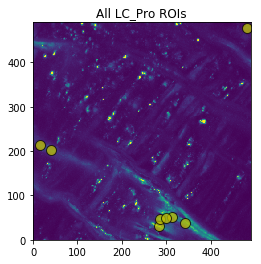

In [45]:
all_roi_2d(roi_loc , im , s=100)

### - Select Roi and Friends plot

Call a 2d plot with each roi on it. Choose an roi by name (ex: 'Roi35') to see it's relationship to all other rois. The named roi will be in white. All other roi's will be colored by its r value. 

when just_friends = True, only friends who meet the r threshold will be shown and all others will be gray. when just_friends = False, all rois will be colored based on r value.

Save this plot from the pop up graph window.

KeyError: 'Roi103'

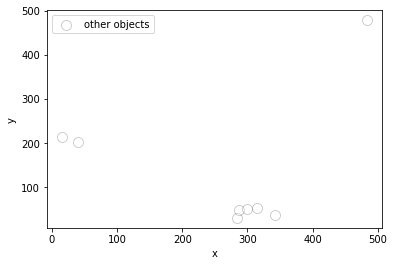

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

def friend_roi_2d(data_corr, friend_names, roi_loc, r, d, roi='Roi103', just_friends=True, s=100):
    # Create scatter plots
    sns.scatterplot(x=roi_loc.x, y=roi_loc.y, label='other objects', s=s, color='w', edgecolor='k', alpha=0.25)
    scatter = sns.scatterplot(x=roi_loc.x[friend_names[roi]], y=roi_loc.y[friend_names[roi]], s=s, hue=friend_names[roi], palette='Spectral', edgecolor='k', alpha=1)
    
    # Remove legend
    scatter.legend_.remove()
    
    # Create colorbar
    cbar = plt.colorbar(scatter.collections[0], ax=scatter.axes)
    cbar.set_label('Friend Index')
    
    # Show plot
    sns.despine()
    plt.show()

# Assuming you call the function with appropriate arguments
friend_roi_2d(data_corr, friend_names, roi_loc, r, d, roi='Roi103', just_friends=True, s=100)


## B. Line Plots

All line plots are scaled the same: 0 to the maximum value in the entire dataframe.

### - Line Plots for all ROIs

Use all_roi_line_pdfs to plot each ROI as its own pdf. Each plot is randomly assigned a color. You cannot disable this feature.

you can easily consolidate all of these into a single pdf using adobe or another preview program.

In [24]:
all_roi_line_pdfs(data, num_rois = len(data.columns), ymin = 0, ymax=max(data.max()), events_x = events_x, events_y = events_y, folder = folder)

/Users/devinwilson/anaconda3/envs/RAAIM/lib/python2.7/site-packages/ipykernel_launcher.py:265: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### - Line Plot for only one ROI

Use roi_line_plot to call an ROI and get its plot. It includes the overlay of the LCPro events

/Users/devinwilson/anaconda3/envs/RAAIM/lib/python2.7/site-packages/ipykernel_launcher.py:279: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


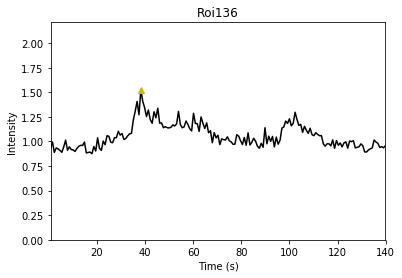

In [352]:
roi_line_plot(roi = 'Roi136', dataframe = data, events_x = events_x, events_y=events_y, ymin = 0, ymax=max(data.max()))

### - Stacked line plot of an ROI and its friends

Call an roi by name (ex: 'Roi35') to get a line plot of it and its friends. Save this plot from the pop up graph window.

In [ ]:
friend_roi_line(data, friend_names, roi = 'Roi136', folder = folder)

### - Average line plot of an ROI and its friends

Call an roi by name (ex: 'Roi35') to get a line plot of the average of it and its friends. the average standard error for each point is printed below once the plot is closed. Save this plot from the pop up graph window.

In [ ]:
friend_roi_line_average(data, friend_names, roi = 'Roi136')

### - Autocorrelation Plot

In [ ]:
roi = 'Roi136'

autocorrelation_plot(data[roi])
plt.title(roi)
plt.show()

## C. Box and Whister Plots

Call an ROI and see the distribution of either its friends' correlations or neighbors' distances.

Choose which metrc to use by changing flavor to either 'dist' or 'corr'

In [ ]:
boxandwhiskers(roi = 'Roi136', flavor = 'corr', data_corr = data_corr, roi_dist = roi_dist, r = r, d = d)

# End

# ............................................................................................................................................

## [ Run the next cells of code if you want to randomize the dataset ]

In [ ]:
import random

def shuffle(x):
    random.shuffle(x)
    return x

for label, column in data.iteritems():
    tempcol = data[label].tolist()
    randcol = shuffle(tempcol)  #shuffle the list of values in the column
    data[label] = randcol #write over the original list with randomized list

### Check that the dataset set is indeed randomized! Compare this table to the table under the header "(b) Load"

In [200]:
data.head()

,Roi18,Roi21,Roi62,Roi66,Roi67
time(s),,,,,
0.78125,0.963949,1.782108,1.349198,1.543961,1.379517
1.56250,0.984581,1.741232,1.362327,1.515378,1.414717
2.34375,0.985647,1.753070,1.416037,1.465832,1.382118
3.12500,0.990750,1.741312,1.505475,1.457942,1.375667
3.90625,0.983733,1.745520,1.517991,1.409159,1.465119


### Now, go to analysis and it will run the program with the randomized data. (SKIP I. User Input) 

# ............................................................................................................................................